# Pet Dog Behavior Study Analysis

## 1. Workspace Setup

In [1]:
# Imports accounted for.
import sqlite3
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import numpy as np

# Imports unaccounted for.
import textwrap
import scipy.stats as scs
from IPython.display import display
import plotly.figure_factory as ff

# IPython magics for this notebook.
%matplotlib inline

# Initiate plotly IPython notebook mode.
py.init_notebook_mode(connected=True)

# Establish a connection to the database.
con = sqlite3.connect('../data/processed/processed.db')

## 2. Reasons for Joining the Study

In [2]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_1, question_reason_for_part_2, '  
         'question_reason_for_part_3, question_reason_for_part_4, '
         'question_reason_for_part_5 FROM users')
df = pd.read_sql_query(query, con)
df.columns = ['love for dogs', 'to help shelter animals', 'suspicion of behavior problems',
              'work with animals', 'other']
for col in df:
    df[col] = pd.to_numeric(df[col])
    
# Create a bar graph to illustrate breakdown of responses.
sums = df.sum()
sums = sums.sort_values(ascending=True)
data = [go.Bar(y=sums.index.values,
               x=sums.values,
               orientation='h')]
layout = go.Layout(title="Motivation for Study Enrollment",
                   xaxis=dict(title='number of participants'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=600,
                   height=400)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# NOTE: This does not include a count of users who did not provide a reason.

## 3. Overall Prevalence of Behavior Problems

Prevalence is defined as the proportion of a population found to be affected by a medical condition. This section aims to calculate the aggregate prevalence of the most common behavior problems in a given canine population.

### 3.1 Gross and Adjusted Responses:

In [3]:
# Create the necessary dataframe.
query = ('SELECT record_id, question_reason_for_part_3, q02_score FROM users JOIN dogs '
         'USING(record_id)')
df_gross = pd.read_sql_query(query, con)
df_gross.columns = ['id', 'suspicion', 'problems']

# Get a count of the total number of dogs.
cnt_total_dogs = len(df_gross.index)

# Get a count of the dogs with reported behavior problem.
# If the "problems" column does not equal zero, then a behavior problem was reported.
cnt_total_dogs_w_problems = len(df_gross[df_gross['problems'] != '0'].index)

# Create an adjusted dataframe by removing biased results.
# A result is considered biased if a participant listed "suspicion of a behavior problem" as a
# reason for joining the study.
df_adjusted = df_gross[df_gross['suspicion'] == '0']

# Get a count of the total number of dogs from the adjusted dataframe.
cnt_total_dogs_adjusted = len(df_adjusted.index)

# Get a count of the dogs with a reported behavior problem from the adjusted dataframe.
cnt_total_dogs_w_problems_adjusted = len(df_adjusted[df_adjusted['problems'] != '0'].index)

# Display the count results.
print('Total number of dogs: %d' %cnt_total_dogs)
print('Total number of dogs with a reported behavior problem: %d' %cnt_total_dogs_w_problems)
print('Adjusted total number of dogs: %d' %cnt_total_dogs_adjusted)
print('Adjusted total number of dogs with a reported behavior problem: %d'
      %cnt_total_dogs_w_problems_adjusted)

Total number of dogs: 5018
Total number of dogs with a reported behavior problem: 4407
Adjusted total number of dogs: 3749
Adjusted total number of dogs with a reported behavior problem: 3207


### 3.2 Prevalence of Behavior Problems:

In [4]:
# Calculate the gross prevalence.
prevalence_gross = (cnt_total_dogs_w_problems / cnt_total_dogs) * 100

# Calculate the adjusted prevalence.
prevalence_adjusted = (cnt_total_dogs_w_problems_adjusted / cnt_total_dogs_adjusted) * 100

# Calculate the difference between the gross and adjusted prevalence.
diff_prevalence = prevalence_adjusted - prevalence_gross
sign = '+' if diff_prevalence > 0 else ''

# Display the prevalence results.
print('Gross prevalence: %.2f%% (%d/%d)'
      %(prevalence_gross, cnt_total_dogs_w_problems, cnt_total_dogs))
print('Adjusted prevalence: %.2f%% (%d/%d)'
      %(prevalence_adjusted, cnt_total_dogs_w_problems_adjusted, cnt_total_dogs_adjusted))
print('Shift in prevalence as a result of adjustment: %s%.2f%%' %(sign, diff_prevalence))

Gross prevalence: 87.82% (4407/5018)
Adjusted prevalence: 85.54% (3207/3749)
Shift in prevalence as a result of adjustment: -2.28%


## 4. Prevalence of Individual Behavior Problems

This section aims to calculate the prevalence for each behavior problem included in the study. The adjusted dataset is utilized to eliminate potential bias.

### 4.1 Sum and Prevalence of Individual Behavior Problems:

In [5]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q02_main_1, q02_main_2, q02_main_3, '
         'q02_main_4, q02_main_5, q02_main_6, q02_main_7, q02_main_8, q02_main_9, '
         'q02_main_10, q02_main_12, q02_main_13 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'aggression', 'fear/anxiety', 'compulsion', 'house soiling',
              'excessive barking', 'jumping', 'mounting', 'fecal consumption', 'destruction',
              'rolling in repulsive objects', 'escape', 'hyperactivity']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
total_dogs = len(df.index)
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    header=dict(values=['Behavior Problem', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = dict(width=700, height=450)
fig = dict(data=data, layout=layout)
py.iplot(fig)

### 4.2 Prevalence of Individual Behavior Problems Presented Graphically:

In [6]:
prevalences = prevalences.sort_values(ascending=True)
trace = go.Bar(
    x=prevalences.values,
    y=prevalences.index.values,
    orientation='h')
data = [trace]
layout = go.Layout(title='Prevalence of Behavior Problems',
                   xaxis=dict(title='prevalence (%)'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=700,
                   height=500
                  )
fig = dict(data=data, layout=layout)
py.iplot(fig)

## 5. Behavior Problem Compositions

### 5.1 Types of Aggression

In [7]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q03_main_1, q03_main_2, q03_main_3, '
         'q03_main_4, q03_main_5, q03_main_6, q03_main_7, q03_main_8, q03_main_9, '
         'q03_main_10, q03_main_11 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'familiar people in the home', 'stangers visiting the home',
              'stangers away from the home', 'another dog in the home',
              'unfamiliar dogs visiting the home', 'unfamilair dogs on walks (off lead)',
              'unfamilair dogs on walks (on lead)', 'veterinarians', 'trainers', 'groomers',
              'animals other than dogs in the home']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Type of Aggression', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

In [8]:
# Generate a bar graph.
prevalences = prevalences.sort_values(ascending=True)
trace = go.Bar(
    x=prevalences.values,
    y=prevalences.index.values,
    orientation='h')
data = [trace]
layout = go.Layout(title='Prevalence of Aggression',
                   xaxis=dict(title='prevalence (%)'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=700,
                   height=500
                  )
fig = dict(data=data, layout=layout)
py.iplot(fig)

### 5.2 Types of Fear/Anxiety

In [9]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q04_1, q04_2, q04_3, q04_4, q04_5, q04_6, '
         'q04_7, q04_8, q04_9, q04_10, q04_11 FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'thunderstorm phobia', 'noise phobia', 'crowd phobia',
              'phobia of other dogs', 'PTSD',
              'general anxiety', 'situational anxiety', 'veterinarian phobia',
              'separation anxiety', 'travel anxiety', 'other']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Type of Fear/Anxiety', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

In [10]:
# Generate a bar graph.
prevalences = prevalences.sort_values(ascending=True)
trace = go.Bar(
    x=prevalences.values,
    y=prevalences.index.values,
    orientation='h')
data = [trace]
layout = go.Layout(title='Prevalence of Fear/Anxiety',
                   xaxis=dict(title='prevalence (%)'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=700,
                   height=500
                  )
fig = dict(data=data, layout=layout)
py.iplot(fig)

### 5.3 Types of Compulsion

In [11]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q05_main_1, q05_main_2, q05_main_3, '
         'q05_main_4, q05_main_5, q05_main_6, q05_main_7, q05_main_8, q05_main_9, '
         'q05_main_10, q05_main_11, q05_main_12, q05_main_13 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'spinning', 'tail chasing', 'shadow/light chasing',
              'running in geometric patterns', 'licking of wrist/hock', 'fly snapping',
              'sucking flank region/blankets', 'tennis ball fetish',
              'collecting/arranging objects', 'nail biting', 'digging in yard',
              'stone/rock chewing', 'other']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Type of Compulsion', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

In [12]:
# Generate a bar graph.
prevalences = prevalences.sort_values(ascending=True)
trace = go.Bar(
    x=prevalences.values,
    y=prevalences.index.values,
    orientation='h')
data = [trace]
layout = go.Layout(title='Prevalence of Compulsion',
                   xaxis=dict(title='prevalence (%)'),
                   yaxis=dict(title='',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=700,
                   height=500
                  )
fig = dict(data=data, layout=layout)
py.iplot(fig)

### 5.4 Types of House Soiling

In [13]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q06_situation_1, q06_situation_2, '
         'q06_situation_3 FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'urine', 'feces', 'both']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['House Soiling Type', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.5 House Soiling Locations

In [14]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q06_soil_location_1, q06_soil_location_2 '
         'FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'specific locations', 'anywhere']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['House Soiling Location', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.7 House Soiling Triggers

In [15]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q06_situation_1, q06_situation_2, '
         'q06_situation_3 FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'owner present', 'owner away', 'excited/overwhelmed']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['House Soiling Situation', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.8 Excessive Barking

In [16]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q07_sitatuon_1, q07_sitatuon_2, '
         'q07_sitatuon_3, q07_sitatuon_4, q07_sitatuon_5, q07_sitatuon_6 '
         'FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'owner present', 'owner away', 'to get attention',
              'at tiggers (inside)', 'at triggers (outside)', 'during car rides']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Excessive Barking Scenario', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.9 Jumping

In [17]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q08_who_1, q08_who_2, q08_who_3 '
         'FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'owner', 'family members', 'strangers']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Jumping Target', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.10 Mounting/Humping

In [18]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q09_main_1, q09_main_2, q09_main_3, q09_main_4 '
         'FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'people', 'familiar dogs', 'unfamiliar dogs', 'inanimate objects']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Mounting/Humping Target', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.11 Consumption of Feces

In [19]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q10_main_1, q10_main_2, q10_main_3 '
         'FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'their own', "other dogs'", "other species'"]

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Source of Feces Consumed', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.12 Destructive Behavior

In [20]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q11_situation_1, q11_situation_2 '
         'FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'owner is home', 'owner is away']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Destructive Behavior Situation', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.13 Rolling in Repulsive Materials

In [21]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q10_main_1, q10_main_2, q10_main_3 '
         'FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'urine', 'feces', 'dead stuff']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Rolling in Repulsive Materials', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.14 Running Away

In [22]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q14_out, q14_house, q14_conf, q14_return FROM '
         'users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'escapes when out', 'escapes from home',
              'escapes from confinement', 'returns home after escape']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Running Away', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

### 5.15 Types of Overactivity/Hyperactivity

In [23]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q15_main_1, q15_main_2, q15_main_3, q15_main_4 '
         'FROM users JOIN dogs USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'constant moving/jumping', 'difficulty settling',
              'highly distractible', 'impulsive']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    columnwidth = [200, 100, 100],
    header=dict(values=['Overactivity/Hyperactivity', 'Number of Dogs', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
py.iplot(data)

## 6. Separation Anxiety, Noise Phobia, and Thunderstorm Phobia

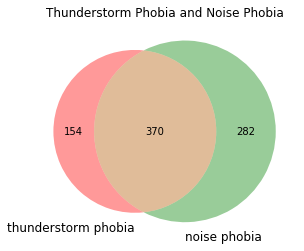

Chi-squared Test of Independence for thunderstorm phobia and noise phobia:
chi2 = 1200.877626, p = 3.93E-263, dof = 1
The resulting p-value is below the set significance threshold (0.01).


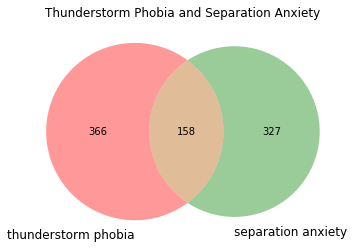

Chi-squared Test of Independence for thunderstorm phobia and separation anxiety:
chi2 = 160.293122, p = 9.76E-37, dof = 1
The resulting p-value is below the set significance threshold (0.01).


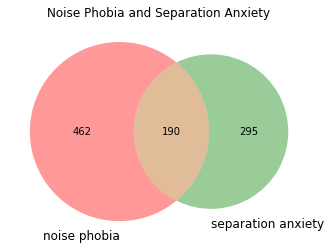

Chi-squared Test of Independence for noise phobia and separation anxiety:
chi2 = 184.001984, p = 6.48E-42, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [24]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q04_1, q04_2, q04_9 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'thunderstorm phobia', 'noise phobia', 'separation anxiety']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert all columns to type integer.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Set a significance level.
sig_p = 0.01

pairs = [['thunderstorm phobia', 'noise phobia'],
         ['thunderstorm phobia', 'separation anxiety'],
         ['noise phobia', 'separation anxiety']]

titles = ['Thunderstorm Phobia and Noise Phobia',
          'Thunderstorm Phobia and Separation Anxiety',
          'Noise Phobia and Separation Anxiety']

counter = 0
for pair in pairs:
    # Create a contingency table.
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    # Convert the cross tabulated dataframe to a series of sums.
    d = {pair[0]: contingency[0][1],
         pair[1]: contingency[1][0],
         'both': contingency[1][1]}   
    cross_sums = pd.Series(d)
    # Display the cross tabulated data as a venn diagram.
    labels = cross_sums.index.values
    venn2(cross_sums, set_labels=labels[0:2])
    plt.title(titles[counter])
    plt.show()
    # Execute a chi-squared test of independence.
    print('Chi-squared Test of Independence for %s and %s:' %(pair[0], pair[1]))
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
    if p < sig_p:
        print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)
    counter += 1

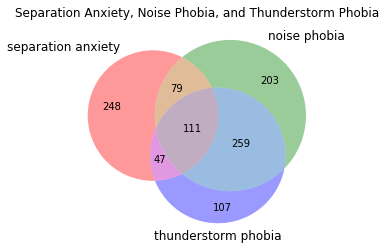

Chi-squared Test of Independence for separation anxiety and the combination of noise and
thunderstorm phobia:
chi2 = 247.979410, p = 1.79E-53, dof = 3
The resulting p-value is below the set significance threshold (0.01).


In [25]:
# Create a contingency table.
contingency = pd.crosstab(df['separation anxiety'], [df['noise phobia'],
                                                     df['thunderstorm phobia']])

# Convert the cross tabulated dataframe to a series of sums.
d = {'separation anxiety': contingency[0][0][1],
     'noise phobia': contingency[1][0][0],
     'separation-noise': contingency[1][0][1],
     'thunderstorm phobia': contingency[0][1][0],
     'separation-thunderstorm': contingency[0][1][1],
     'noise-thunderstorm': contingency[1][1][0],     
     'all': contingency[1][1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = [cross_sums.index.values[i] for i in [0, 1, 3]]
venn3(cross_sums, set_labels=labels)
plt.title('Separation Anxiety, Noise Phobia, and Thunderstorm Phobia')
plt.show()

# Execute a chi-squared test of independence.
title = ('Chi-squared Test of Independence for separation anxiety and the combination of '
         'noise and thunderstorm phobia:')
print(textwrap.fill(title, width=90))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

## 7. Compulsion and Fearful/Anxious Behaviors

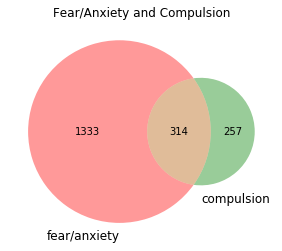

In [26]:
# Create the necessary hdataframe.
query = ('SELECT question_reason_for_part_3, q02_main_2, q02_main_3 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'fear/anxiety', 'compulsion']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert all columns to type integer.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df['fear/anxiety'], df['compulsion'])

# Convert the cross tabulated dataframe to a series of sums.
d = {'fear/anxiety': contingency[0][1],
     'compulsion': contingency[1][0],
     'both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
venn2(cross_sums, set_labels=labels[0:2])
plt.title('Fear/Anxiety and Compulsion')
plt.show()

In [27]:
# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

Chi-square Test of Independence:
chi2 = 33.448407, p = 7.32E-09, dof = 1
The resulting p-value is below the set significance threshold (0.01).


## 8. Aggression and Fearful/Anxious Behavior

### 8.1 Overall Aggression and Fearful/Anxious Behavior

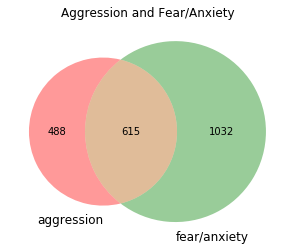

Chi-square Test of Independence:
chi2 = 88.721901, p = 4.54E-21, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [28]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q02_main_1, q02_main_2 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'aggression', 'fear/anxiety']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert all columns to type integer.
for col in df:
    df[col] = pd.to_numeric(df[col])
    
# Create a contingency table.
contingency = pd.crosstab(df['aggression'], df['fear/anxiety'])

# Convert the cross tabulated dataframe to a series of sums.
d = {'aggression': contingency[0][1],
     'fear/anxiety': contingency[1][0],
     'both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
venn2(cross_sums, set_labels=labels[0:2])
plt.title('Aggression and Fear/Anxiety')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

### 8.2 Specifically Owner Directed Aggression and Fearful/Anxious Behavior

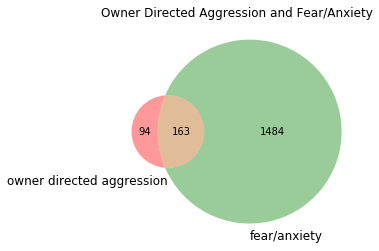

Chi-square Test of Independence:
chi2 = 42.560816, p = 6.85E-11, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [29]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q03_main_1, q02_main_2 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'aggression', 'fear/anxiety']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert all columns to type integer.
for col in df:
    df[col] = pd.to_numeric(df[col])
    
# Create a contingency table.
contingency = pd.crosstab(df['aggression'], df['fear/anxiety'])

# Convert the cross tabulated dataframe to a series of sums.
d = {'owner directed aggression': contingency[0][1],
     'fear/anxiety': contingency[1][0],
     'both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
venn2(cross_sums, set_labels=labels[0:2])
plt.title('Owner Directed Aggression and Fear/Anxiety')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

### 8.3 Specifically Owner Directed Aggression and Separation Anxiety

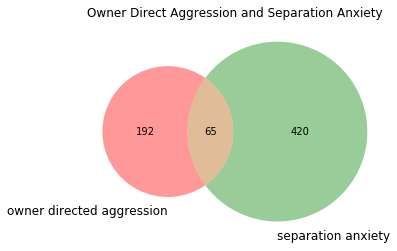

Chi-square Test of Independence:
chi2 = 37.394009, p = 9.65E-10, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [30]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q03_main_1, q04_9 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'aggression', 'anxiety']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert all columns to type integer.
for col in df:
    df[col] = pd.to_numeric(df[col])
    
# Create a contingency table.
contingency = pd.crosstab(df['aggression'], df['anxiety'])

# Convert the cross tabulated dataframe to a series of sums.
d = {'owner directed aggression': contingency[0][1],
     'separation anxiety': contingency[1][0],
     'both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
venn2(cross_sums, set_labels=labels[0:2])
plt.title('Owner Direct Aggression and Separation Anxiety')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

## 9. Chi-squared Matrix

In [31]:
query = ('SELECT question_reason_for_part_3, q03_main_1, q03_main_2, q03_main_3, '
         'q03_main_4, q03_main_5, q03_main_6, q03_main_7, q03_main_8, q03_main_9, '
         'q03_main_10, q03_main_11 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

cols = []
chi2 = {}
# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])
    cols.append(col)
    chi2[col] = {}

from  itertools import combinations
pairs = list(combinations(df.columns,2))
for pair in pairs:
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    chi2[pair[0]][pair[1]] = c
chi2_matrix = np.array([chi2[i] for i in cols])
print(chi2_matrix)

[{'A2': 254.7591681771337, 'A3': 98.9685690679733, 'A4': 299.52379089035423, 'A5': 112.57016475353687, 'A6': 79.20184360179715, 'A7': 92.83831101413091, 'A8': 343.9268929197353, 'A9': 106.8558936749317, 'A10': 207.17616381950012, 'A11': 132.45075050814378}
 {'A3': 1182.3705027968695, 'A4': 216.05045002659682, 'A5': 355.8310750402481, 'A6': 200.34542986282952, 'A7': 311.8329567296948, 'A8': 345.85869134688943, 'A9': 222.0356704399084, 'A10': 107.74577588652066, 'A11': 95.49007438660502}
 {'A4': 150.54274433956604, 'A5': 239.00207506639015, 'A6': 297.3238504052413, 'A7': 546.8174324078923, 'A8': 414.86874956107744, 'A9': 153.52639655243942, 'A10': 62.29257480456627, 'A11': 85.07359919143074}
 {'A5': 590.057561324062, 'A6': 209.03507873426452, 'A7': 282.0067905187461, 'A8': 131.7846223093362, 'A9': 63.50545555631838, 'A10': 68.44564727640159, 'A11': 355.49941732757674}
 {'A6': 781.4761265955761, 'A7': 715.8126259774235, 'A8': 138.91424141357015, 'A9': 78.58765204991913, 'A10': 37.95674701